# Kubeflow Pipelines

## Introduction
With [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/) you can build entire workflows that automate the steps involved in going from training a machine learning model to actually serving an optimized version of it.
These steps can be triggered automatically by a CI/CD workflow or on demand from a command line or notebook.

Kubeflow Pipelines (`kfp`) comes with a user interface for managing and tracking experiments, jobs, and runs.
A pipeline is a description of a machine learning workflow, replete with all inputs and outputs.
In Kubeflow Pipelines, an **experiment** is a [workspace](../metadata/Metadata%20SDK.ipynb) where you can _experiment with_ different configuration of your pipelines.
Experiments are a way to organize runs of jobs into logical groups.
A **run** is simply a single execution (instance) of a pipeline.
Kubeflow Pipelines also supports recurring runs, which is a repeatable run of a pipeline.
Based on a so-called **run trigger** an instance of a pipeline with its run configuration is periodically started.
As of now, [run triggers](https://www.kubeflow.org/docs/pipelines/overview/concepts/run-trigger/) are time-based (i.e. not event-based).

In the UI, there is a pictorial representation of the runtime execution of a pipeline.
This **graph** consists of one or more steps (i.e. nodes).
Each step
The directed edges (arrows) show the parent/child relationship: A &rarr; B means that B depends on A; B cannot start until A has successfully completed.

A **component** performs a single step in the pipeline (e.g. data ingestion, data preprocessing, data transformation, model training, hyperparameter tuning).
It is analogous to a function: it has a name, (metadata) parameters and return values (interface), and a body (implementation).
It must therefore be self-contained.
Each component must be packaged as a Docker image.
Please note that components are independently executed: they do not share the same process and cannot share in-memory data.

### What You'll Learn
This notebook trains a simple (MNIST) model in TensorFlow and serves it with [KFServing](https://www.kubeflow.org/docs/components/serving/kfserving/), which is a serverless inference server.
What this means is that you do not have to worry about which machines it runs on, networking, autoscaling, health checks, and what have you.
Instead, you can focus on what matters to you: the model and a REST API you can call for predictions.
If you are familiar with Kubernetes, you can even do [out-of-the-box canary deployments](https://github.com/kubeflow/kfserving/tree/master/docs/samples/tensorflow), in which a percentage of traffic is directed to the 'canary (in the coal mine)' with the latest model to ensure it functions properly before completely rolling out any (potentially problematic) updates.

If you prefer to use a more sophisticated model or a PyTorch-based one, you can check out the relevant notebooks: [MNIST with TensorFlow](../training/tensorflow/MNIST%20with%20TensorFlow.ipynb) or [MNIST with PyTorch](../training/pytorch/MNIST%20with%20PyTorch.ipynb).

KFServing reads the model file from [MinIO](https://min.io/), an open-source S3-compliant object storage tool, which is already included with your Kubeflow installation.

We also use MinIO to provide the input data set to the pipeline. This way it can run without a connection to the Internet.

### What You'll Need
This notebook.

## Prerequisites
Let's make sure Kubeflow Pipelines is available:

### Copy input data set into MinIO using its CLI

First, we configure credentials for `mc`, the MinIO command line client.
We then use it to create a bucket, upload the dataset to it, and set access policy so that the pipeline can download it from MinIO.

In [44]:
! ./mc alias set minio http://minio-service.kubeflow:9000 mlopstestnplink D6N1ErV++1pUSrjGPZCW48UKMSEzxMf1884l5j/eqk99ZkIMbgpmUTRFs3zPsZGWX42iD7IwdwDTxr9ZNHPTeA==

Added `minio` successfully.


In [45]:
! ./mc mb minio/bucket5

mc: <ERROR> Unable to make bucket `minio/bucket5`. Your previous request to create the named bucket succeeded and you already own it.


In [46]:
! tar --dereference -czf datasets.tar.gz ./datasets
! ./mc cp datasets.tar.gz minio/bucket5/datasets.tar.gz
! ./mc policy set download minio/bucket5

...ts.tar.gz:  27.10 MiB / 27.10 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 34.55 MiB/s 0smc: <ERROR> Unable to set policy `download` for `minio/bucket5`. unsupported Resource found [arn:aws:s3:::bucket5/*] for action s3:ListBucket.


## How to Implement Kubeflow Pipelines Components
As we said before, components are self-contained pieces of code: Python functions.

<div class="alert alert-block alert-warning">
    The function must be completely self-contained.
    No code (incl. imports) can be defined outside of the body itself.
    All imports <a href="https://www.kubeflow.org/docs/pipelines/sdk/lightweight-python-components/">must be included</a> in the function body itself!
    Imported packages must be available in the base image.<br><br>
    Why? Because each component will be packaged as a Docker image.
    The base image must therefore contain all dependencies.
    Any dependencies you install manually in the notebook are invisible to the Python function once it's inside the image.
    The function itself becomes the entrypoint of the image, which is why all auxiliary functions must be defined inside the function.
    That does cause some unfortunate duplication, but it also means you do not have to worry about the mechanism of packaging, as we shall see below.
</div>

For our pipeline, we shall define four components:
- Download the MNIST data set
- Train the TensorFlow model
- Evaluate the trained model
- Export the trained model
- Serve the trained model

We also need the current Kubernetes namespace, which we can dynamically grab using [Kubeflow Fairing](../fairing/Kubeflow%20Fairing.ipynb).

In [47]:
from typing import NamedTuple

import kfp
import kfp.components as components
import kfp.dsl as dsl
import kubeflow.fairing.utils

from kfp.components import InputPath, OutputPath

NAMESPACE = kubeflow.fairing.utils.get_current_k8s_namespace()

Function arguments specified with `InputPath` and `OutputPath` are the key to defining dependencies.
For now, it suffices to think of them as the input and output of each step.
How we can define dependencies is explained in the [next section](#How-to-Combine-the-Components-into-a-Pipeline).

### Component 1: Download the MNIST Data Set

In [48]:
def download_dataset(data_dir: OutputPath(str)):
    """Download the MNIST data set to the KFP volume to share it among all steps"""
    import urllib.request
    import tarfile
    import os

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    url = "http://minio-service.kubeflow:9000/bucket5/datasets.tar.gz"
    stream = urllib.request.urlopen(url)
    tar = tarfile.open(fileobj=stream, mode="r|gz")
    tar.extractall(path=data_dir)

### Component 2: Train the Model
For both the training and evaluation we must divide the integer-valued pixel values by 255 to scale all values into the [0, 1] (floating-point) range.
This function must be copied into both component functions (cf. `normalize_image`).

If you wish to learn more about the model code, please have a look at the [MNIST with TensorFlow](../training/MNIST%20with%20TensorFlow.ipynb) notebook.

In [49]:
def train_model(data_dir: InputPath(str), model_dir: OutputPath(str)):
    """Trains a single-layer CNN for 5 epochs using a pre-downloaded dataset.
    Once trained, the model is persisted to `model_dir`."""

    import os
    import tensorflow as tf
    import tensorflow_datasets as tfds

    def normalize_image(image, label):
        """Normalizes images: `uint8` -> `float32`"""
        return tf.cast(image, tf.float32) / 255.0, label

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=["accuracy"],
    )

    print(model.summary())
    ds_train, ds_info = tfds.load(
        "mnist",
        split="train",
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        download=False,
        data_dir=f"{data_dir}/datasets",
    )

    # See: https://www.tensorflow.org/datasets/keras_example#build_training_pipeline
    ds_train = ds_train.map(
        normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

    model.fit(
        ds_train,
        epochs=5,
    )

    model.save(model_dir)
    print(f"Model saved {model_dir}")
    print(os.listdir(model_dir))

# Hyperparameter Tuning with Katib

## Introduction

Hyperparameter tuning is the process of optimizing a model's hyperparameter values in order to maximize the predictive quality of the model.
Examples of such hyperparameters are the learning rate, neural architecture depth (layers) and width (nodes), epochs, batch size, dropout rate, and activation functions.
These are the parameters that are set prior to training; unlike the model parameters (weights and biases), these do not change during the process of training the model.

[Katib](https://github.com/kubeflow/katib) automates the process of hyperparameter tuning by running a pre-configured number of training jobs (known as **trials**) in parallel.
Each trial evaluates a different set of hyperparameter configurations.
Within each **experiment** it automatically adjusts the hyperparameters to find their optimal values with regard to the objective function, which is typically the model's metric (e.g. accuracy, AUC, F1, precision).
An experiment therefore consists of an objective, a search space for the hyperparameters, and a [search algorithm](https://github.com/kubeflow/katib#hyperparameter-tuning).
At the end of the experiment, Katib outputs the optimized values, which are also known as **suggestions**.

<div class="alert alert-block alert-info">
    <b>Three Data Sets</b><br>Whereas it is common to have training and test data sets in traditional (supervised) machine learning, in deep learning (esp. when combined with hyperparameter tuning), it is recommended to have a three-way split: training, validation (a.k.a. as development), and test. 
    The training data set is, as always, to learn parameters (weights and biases) from data. 
    The test data set is also known as the hold-out set and its sole purpose is to check the model's hypothesis of parameter values in terms of how well it generalizes to data it has never come across.
    The point of the validation data set is to cross-validate the model and tweak the hyperparameters. 
    Since information from this data set is used to adjust the model, it is not an objective test of the model's generalizability. 
    It is not unlike a <a href=\"https://www.linkedin.com/posts/activity-6424581736302284800-Kdas\">teacher checking up on students</a>:
    <ul>
      <li>The training data set is the text book to learn the theory from</li>
      <li>The validation data set comprises the exercises to practice the theory</li>
      <li>The test data set is exam to assess the degree of learning vs lookup</li>
    </ul>
</div>

### What You'll Learn
This notebook shows how you can create and configure an `Experiment` for both `TensorFlow` and `PyTorch` training jobs.
In terms of Kubernetes, such an experiment is a custom resource handled by the Katib operator.

### What You'll Need
A Docker image with either a [TensorFlow](../training/tensorflow/MNIST%20with%20TensorFlow.ipynb) or [PyTorch](../training/pytorch/MNIST%20with%20PyTorch.ipynb) model that accepts hyperparameters as arguments.
Please click on the links to see such models.

That's it, so let's get started!

## How to Specify Hyperparameters in Your Models
In order for Katib to be able to tweak hyperparameters it needs to know what these are called in the model.
Beyond that, the model must specify these hyperparameters either as regular (command line) parameters or as environment variables.
Since the model needs to be containerized, any command line parameters or environment variables must to be passed to the container that holds your model.
By far the most common and also the recommended way is to use command line parameters that are captured with [`argparse`](https://docs.python.org/3/library/argparse.html) or similar; the trainer (function) then uses their values internally.

## How to Expose Model Metrics as Objective Functions
By default, Katib collects metrics from the standard output of a job container by using a sidecar container.
In order to make the metrics available to Katib, they must be logged to [stdout](https://www.kubeflow.org/docs/components/hyperparameter-tuning/experiment/#metrics-collector) in the `key=value` format.
The job output will be redirected to `/var/log/katib/metrics.log` file.
This means that the objective function (for Katib) must match the metric's `key` in the models output.
It's therefore possible to define custom model metrics for your use case.

<div class="alert alert-block alert-info">
    <b>Sidecars</b><br>
    In the sidecar (a.k.a. sidekick or decomposition) pattern, if you are not already familiar with it, a secondary (sidecar) container is attached to the primary workload inside a pod in Kubernetes. In many cases, pods run a single container, but peripheral services, such as networking services, monitoring, and logging, are required in all applications and services. With sidecars there is no need to re-implement basic but secondary tasks in each service or application. The sidecar has the same lifecycle as the primary application and it has access to the same resources. The sidecar is, however, isolated from the main container, which means it does not have to be implemented in the same technology. This means it can easily be reused across various workloads.<br><br>
    Katib does not care whether you use TensorFlow, PyTorch, MXNet, or any other framework for that matter. All it needs to do its job is a (parameterized) trainer container and the logs to grab the model's metrics from.
</div>

## How to Create Experiments
Before we proceed, let's set up a few basic definitions that we can re-use.
Note that you typically use (YAML) resource definitions for Kubernetes from the command line, but we shall show you how to do everything from a notebook, so that you do not have to exit your favourite environment at all!
Of course, if you are more familiar or comfortable with `kubectl` and the command line, feel free to use a local CLI or the embedded terminals from the Jupyter Lab launch screen.

In [50]:
! kubectl apply -f katib.yaml

experiment.kubeflow.org/experiment unchanged


### Component 3: Evaluate the Model
With the following Python function the model is evaluated.
The metrics [metadata](https://www.kubeflow.org/docs/pipelines/sdk/pipelines-metrics/) (loss and accuracy) is available to the Kubeflow Pipelines UI.
Metadata can automatically be visualized with output viewer(s).
Please go [here](https://www.kubeflow.org/docs/pipelines/sdk/output-viewer/) to see how to do that.

In [51]:
def evaluate_model(
    data_dir: InputPath(str), model_dir: InputPath(str), metrics_path: OutputPath(str)
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):
    """Loads a saved model from file and uses a pre-downloaded dataset for evaluation.
    Model metrics are persisted to `/mlpipeline-metrics.json` for Kubeflow Pipelines
    metadata."""

    import json
    import tensorflow as tf
    import tensorflow_datasets as tfds
    from collections import namedtuple

    def normalize_image(image, label):
        return tf.cast(image, tf.float32) / 255.0, label

    ds_test, ds_info = tfds.load(
        "mnist",
        split="test",
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        download=False,
        data_dir=f"{data_dir}/datasets",
    )

    # See: https://www.tensorflow.org/datasets/keras_example#build_training_pipeline
    ds_test = ds_test.map(
        normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(ds_test)

    metrics = {
        "metrics": [
            {"name": "loss", "numberValue": str(loss), "format": "PERCENTAGE"},
            {"name": "accuracy", "numberValue": str(accuracy), "format": "PERCENTAGE"},
        ]
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))

### Component 4: Export the Model

In [73]:
def export_model(
    model_dir: InputPath(str),
    metrics: InputPath(str),
    export_bucket: str,
    model_name: str,
    model_version: int,
):
    import os
    import boto3
    from botocore.client import Config

    s3 = boto3.client(
        "s3",
        endpoint_url="http://minio-service.kubeflow:9000",
        aws_access_key_id="mlopstestnplink",
        aws_secret_access_key="D6N1ErV++1pUSrjGPZCW48UKMSEzxMf1884l5j/eqk99ZkIMbgpmUTRFs3zPsZGWX42iD7IwdwDTxr9ZNHPTeA==",
        config=Config(signature_version="s3v4"),
    )

    # Create export bucket if it does not yet exist
    response = s3.list_buckets()
    export_bucket_exists = False

    for bucket in response["Buckets"]:
        if bucket["Name"] == export_bucket:
            export_bucket_exists = True

    if not export_bucket_exists:
        s3.create_bucket(ACL="public-read-write", Bucket=export_bucket)

    # Save model files to S3
    for root, dirs, files in os.walk(model_dir):
        for filename in files:
            local_path = os.path.join(root, filename)
            s3_path = os.path.relpath(local_path, model_dir)

            s3.upload_file(
                local_path,
                export_bucket,
                f"{model_name}/{model_version}/{s3_path}",
                ExtraArgs={"ACL": "public-read"},
            )

    response = s3.list_objects(Bucket=export_bucket)
    print(f"All objects in {export_bucket}:")
    for file in response["Contents"]:
        print("{}/{}".format(export_bucket, file["Key"]))

# Metadata SDK

## Introduction
All information about executions, models, data sets as well as the files and objects that are a part of a machine learning workflow are referred to as metadata.
The [Metadata SDK](https://www.kubeflow.org/docs/components/metadata/) allows you to manage all ML assets:

- An [`Execution`](https://kubeflow-metadata.readthedocs.io/en/latest/source/md.html#kubeflow.metadata.metadata.Execution) captures metadata of a single run of an ML workflow, which can be either a pipeline or a notebook. Any derived data that is used or produced in the context of a single execution is referred to as an **artifact**.
- Metadata of a [`Model`](https://kubeflow-metadata.readthedocs.io/en/latest/source/md.html#kubeflow.metadata.metadata.Model) includes a URI to its location, a name and description, training framework (e.g. TensorFlow, PyTorch, MXNet), hyperparameters and their values, and so on.
- [`Metrics`](https://kubeflow-metadata.readthedocs.io/en/latest/source/md.html#kubeflow.metadata.metadata.Metrics) collect evaluation metrics of the model
- A [`DataSet`](https://kubeflow-metadata.readthedocs.io/en/latest/source/md.html#kubeflow.metadata.metadata.DataSet) describes the data that is either the input or output of a component within an ML workflow.

Behind the scenes, the Metadata SDK uses the gRPC service of [MLMD](https://github.com/google/ml-metadata/blob/master/g3doc/get_started.md), the ML Metadata library, which was originally designed for [TFX](https://github.com/tensorflow/tfx) (TensorFlow eXtended) and offers both implementations for SQLite and MySQL.

With the Metadata SDK you can also add so-called [metadata watchers](https://github.com/kubeflow/metadata/blob/master/watcher/README.md) to check up on Kubernetes resource changes and to save the related data in the metadata service.

### What You'll Learn
In this notebook, you'll learn how to use the Metadata SDK to display information about executions and interact with the metadata available within Kubeflow.

### What You'll Need
Nothing except this notebook.

## How to Create a Workspace
A [workspace](https://kubeflow-metadata.readthedocs.io/en/latest/source/md.html#kubeflow.metadata.metadata.Workspace) is a grouping of pipelines, notebooks, and their artifacts.
A single workspace can hold multiple executions.

To define various objects (e.g. executions, runs, models) you therefore need to create a workspace.
Unless you define multiple workspaces within the same context, you do not have to specify it after you have created 

Let's import the metadata modules and store the default DNS for the host as well as the port for the [metadata store](https://kubeflow-metadata.readthedocs.io/en/latest/source/md.html#kubeflow.metadata.metadata.Store) in a couple of variables:

In [74]:
import kubeflow.metadata
from kubeflow.metadata import metadata

In [75]:
METADATA_STORE_HOST = "metadata-grpc-service.kubeflow"
METADATA_STORE_PORT = 8080

METADATA_STORE = metadata.Store(
    grpc_host=METADATA_STORE_HOST, grpc_port=METADATA_STORE_PORT
)

[I 210319 08:48:08 metadata_store:80] MetadataStore with gRPC connection initialized


In [76]:
ws1 = metadata.Workspace(
    # Connect to metadata service in namespace kubeflow in k8s cluster.
    store=metadata.Store(grpc_host=METADATA_STORE_HOST, grpc_port=METADATA_STORE_PORT),
    name="Mnist Workspace",
    description="Artifact on Mnist Workspace",
    labels={"n1": "v1"})

[I 210319 08:48:08 metadata_store:80] MetadataStore with gRPC connection initialized


This creates a `demo workspace` with a custom label `some_key` that holds the `a-value`.
Labels are typically used to enable easier filtering.
These are (as of yet) not part of the Kubeflow central dashboard, but they can be used to filter by means of the SDK.

## How to Create a Run in a Workspace
The difference between runs and executions is subtle: an execution records the run of a component or step in a machine learning workflow (along with its runtime parameters).

A run is an instance of an executable step. 

An execution therefore always _refers_ to a run.

We'll also define a helper function:

In [77]:
from uuid import uuid4


def add_suffix(name: str) -> str:
    """
    Appends an underscore and hexidecimal UUID to `name`

    :param str name: String to be suffixed
    :return: Suffixed string
    :rtype: str
    """
    return f"{name}_{uuid4().hex}"


run = metadata.Run(
    workspace=ws1,
    name=add_suffix("run"),
    description="A run in our workspace",
)


## How to Create an Execution of a Run

In [78]:
exec = metadata.Execution(
    name=add_suffix("execution"),
    workspace=ws1,
    run=run,
    description="An execution of our run",
)

print(f"Execution ID: {exec.id}")

Execution ID: 44


## How to Log Artifacts for an Execution
An execution can have both _input_ and _output_ artifacts.
Artifacts that can be logged for executions are `Model`, `DataSet`, `Metrics`, or a [custom artifact type](https://kubeflow-metadata.readthedocs.io/en/latest/source/md.html#kubeflow.metadata.metadata.Artifact).

You can see defined artifacts by navigating to the Kubeflow Central Dashboard's Artifact Store.


### How to Log a Data Set
A data set that is used by the model itself is an input artifact.
It can be registered as follows:

In [79]:
date_set_version = add_suffix("ds")

data_set = exec.log_input(
    metadata.DataSet(
        description="Sample data",
        name="mnist-example",
        owner="mnist@kubeflow.com",
        uri="s3://mnist/mnist",
        version=date_set_version,
        query="SELECT * FROM mnist",
    )
)

print(f"Data set ID:      {data_set.id}")
print(f"Data set version: {data_set.version}")

Data set ID:      79
Data set version: ds_be12b0599bc54537af48a6bb6aacaddd


The data itself is available at the specified `uri`.
The `query` is optional and _documents_ how this data is fetched from the source.
It is not used to retrieve it.
After all, the data does not have to live in a relational database at all.

### How to Log a Model
If a step of a machine learning workflow generates a model, it is logged as an output artifact:

In [80]:
model_version = add_suffix("model")

model = exec.log_output(
    metadata.Model(
        name="MNIST",
        description="Model to recognize handwritten digits",
        owner="owner@my-company.com",
        uri="s3://mnist/mnist",
        model_type="neural network",
        training_framework={"name": "tensorflow", "version": "v1.0"},
        hyperparameters={
            "learning_rate": 0.5,
            "layers": [10, 3, 1],
            "early_stop": True,
        },
        version=model_version,
        labels={"a_label": "some-value"},
    )
)

print(f"Model ID:      {model.id}")
print(f"Model version: {model.version}")

Model ID:      80
Model version: model_99201658228946958782d75f31ab08dc


### How to Log the Evaluation of a Model

In [81]:
metrics = exec.log_output(
    metadata.Metrics(
        name="MNIST evaluation",
        description="Evaluation of the MNIST model",
        owner="mnist@kubeflow.com",
        uri="s3://mnist/mnist",
        data_set_id=str(data_set.id),
        model_id=str(model.id),
        metrics_type=metadata.Metrics.VALIDATION,
        values={"accuracy": 0.95},
        labels={"mylabel": "l1"},
    )
)

print(f"Metrics ID: {metrics.id}")

Metrics ID: 81


Possible values for `metrics_type`:
- `TRAINING`
- `VALIDATION`
- `TESTING`
- `PRODUCTION`

If you are not familiar with the distinction between validation and training, please check out the [notebook on hyperparameter tuning](../katib/Hyperparameter%20Tuning.ipynb), which explains the difference and the need for an additional evaluation step.

## How to Add Metadata for Serving the Model
Once you're satisfied with the model, you want to serve it.
The model server is an execution with a model as input artifact:

In [82]:
app = metadata.Execution(
    name="Serving the MNIST model",
    workspace=ws1,
    description="An execution to represent the model serving component",
)

served_model = metadata.Model(
    name="MNIST",
    uri="s3://mnist/mnist",
    version=model.version,
)

m = app.log_input(served_model)

print(f"Serving model with ID:      {m.id}")
print(f"Serving model with version: {m.version}")

Serving model with ID:      80
Serving model with version: model_99201658228946958782d75f31ab08dc


Please note that we use the `name`, `uri`, and `version` to identify the model.
As stated before, only the first two are required, but it's a good practice to also include the version.

## How to List All Models in a Workspace
The Artifact Store is user interface that displays artifacts across all workspaces.
Not all fields are available, which means we cannot filter easily on, say, custom labels.

Fortunately, we can ask for all artifacts of a certain type: `Model`, `Metrics`, `DataSet`, or a custom artifact.
Here's how to list all models:

In [83]:
artifacts = ws1.list(metadata.Model.ARTIFACT_TYPE_NAME)
artifacts

[{'id': 8,
  'workspace': 'Mnist Workspace',
  'run': 'run-2021-03-17T04:35:33.549465',
  'name': 'MNIST',
  'create_time': '2021-03-17T04:35:46.738198Z',
  'owner': 'someone@kubeflow.org',
  'version': 'model_version_22c15ed4-3736-4669-8aa9-68ee9188fa98',
  'model_type': 'neural network',
  'description': 'model to recognize handwritten digits',
  'uri': 'http://minio-service.kubeflow:9000/datastore2/datasets.tar.gz',
  'training_framework': {'name': 'tensorflow', 'version': 'v1.0'},
  'hyperparameters': {'learning_rate': 0.5,
   'layers': [10, 3, 1],
   'early_stop': True},
  'labels': {'mylabel': 'l1'},
  'kwargs': {}},
 {'id': 13,
  'workspace': 'Mnist Workspace',
  'run': 'run-2021-03-17T05:22:55.040282',
  'create_time': '2021-03-17T05:23:10.676749Z',
  'owner': 'someone@kubeflow.org',
  'model_type': 'neural network',
  'version': 'model_version_34b2a27b-03bf-451c-8b66-57704d7dab64',
  'description': 'model to recognize handwritten digits',
  'name': 'MNIST',
  'uri': 'http://mi

In [84]:
import pandas as pd

pd.DataFrame.from_dict(artifacts)

,id,workspace,run,name,create_time,owner,version,model_type,description,uri,training_framework,hyperparameters,labels,kwargs
0,8,Mnist Workspace,run-2021-03-17T04:35:33.549465,MNIST,2021-03-17T04:35:46.738198Z,someone@kubeflow.org,model_version_22c15ed4-3736-4669-8aa9-68ee9188...,neural network,model to recognize handwritten digits,http://minio-service.kubeflow:9000/datastore2/...,"{'name': 'tensorflow', 'version': 'v1.0'}","{'learning_rate': 0.5, 'layers': [10, 3, 1], '...",{'mylabel': 'l1'},{}
1,13,Mnist Workspace,run-2021-03-17T05:22:55.040282,MNIST,2021-03-17T05:23:10.676749Z,someone@kubeflow.org,model_version_34b2a27b-03bf-451c-8b66-57704d7d...,neural network,model to recognize handwritten digits,http://minio-service.kubeflow:9000/datastore2/...,"{'name': 'tensorflow', 'version': 'v1.0'}","{'accuracy': 0.99, 'momentum': [0.6, 0.7], 'lr...",{'mylabel': 'l1'},{}
2,16,Mnist Workspace,run-2021-03-17T05:50:36.394856,MNIST,2021-03-17T05:50:53.555596Z,someone@kubeflow.org,model_version_59ef6f15-92b5-49ea-b84d-db6bed6b...,neural network,model to recognize handwritten digits,http://minio-service.kubeflow:9000/datastore2/...,"{'name': 'tensorflow', 'version': 'v1.0'}","{'accuracy': 0.99, 'momentum': [0.6, 0.7], 'lr...",{'mylabel': 'l1'},{}
3,18,Mnist Workspace,run-2021-03-17T05:54:26.718012,MNIST,2021-03-17T05:54:44.791686Z,someone@kubeflow.org,model_version_d26f985e-260a-4972-b754-0f486b94...,neural network,model to recognize handwritten digits,http://minio-service.kubeflow:9000/datastore2/...,"{'name': 'tensorflow', 'version': 'v1.0'}","{'accuracy': 0.99, 'momentum': [0.6, 0.7], 'lr...",{'mylabel': 'l1'},{}
4,28,Mnist Workspace,run-2021-03-18T06:30:44.909247,MNIST,2021-03-18T06:31:06.022181Z,someone@kubeflow.org,model_version_72be9a17-3472-43f1-a6b6-33b0827a...,neural network,model to recognize handwritten digits,http://minio-service.kubeflow:9000/datastore2/...,"{'name': 'tensorflow', 'version': 'v1.0'}","{'learning_rate': 0.5, 'layers': [10, 3, 1], '...",{'mylabel': 'l1'},{}
5,30,Mnist Workspace,NaN,MNIST,2021-03-18T06:31:45.031903Z,None,model_version_72be9a17-3472-43f1-a6b6-33b0827a...,None,None,http://minio-service.kubeflow:9000/mnist/mnist,None,None,None,{}
6,32,Mnist Workspace,run-2021-03-18T06:41:22.722035,MNIST,2021-03-18T06:41:45.232839Z,someone@kubeflow.org,model_version_199cc53e-65f6-4ebb-948a-7fcaccdb...,neural network,model to recognize handwritten digits,http://minio-service.kubeflow:9000/datastore2/...,"{'name': 'tensorflow', 'version': 'v1.0'}","{'learning_rate': 0.5, 'layers': [10, 3, 1], '...",{'mylabel': 'l1'},{}
7,34,Mnist Workspace,NaN,MNIST,2021-03-18T06:42:27.074194Z,None,model_version_199cc53e-65f6-4ebb-948a-7fcaccdb...,None,None,http://minio-service.kubeflow:9000/mnist/mnist,None,None,None,{}
8,36,Mnist Workspace,run_f603208a75884f3aafaa25356cbb8972,MNIST,2021-03-18T07:27:48.175237Z,owner@my-company.com,model_22719b9def6746ed8f40efef7a661d02,neural network,Model to recognize handwritten digits,gcs://my-bucket/mnist,"{'name': 'tensorflow', 'version': 'v1.0'}","{'learning_rate': 0.5, 'layers': [10, 3, 1], '...",{'a_label': 'some-value'},{}
9,38,Mnist Workspace,NaN,MNIST,2021-03-18T07:28:58.602018Z,None,model_22719b9def6746ed8f40efef7a661d02,None,None,s3://mnist/mnist,None,None,None,{}


You can see the output includes the labels.
Labels are particularly helpful when monitoring many (versions of) models in production, both with regard to system and model performance, as both can affect the overall user experience; a bad prediction (e.g. recommendation) from a responsive service negatively affects the user experience, as does an unresponsive service with good predictions.
Model as well as system performance metrics need to be tracked over time and across versions to ensure a solid user experience.
With (shared) labels it's possible to monitor both simultaneously.

## How to Track Lineage
The same is true of executions and artifacts that belong to certain models

In [85]:
model_events = ws1.store.get_events_by_artifact_ids([model.id])

execution_ids = set(e.execution_id for e in model_events)
print(f"Executions related to the model: {execution_ids}")

trainer_events = ws1.store.get_events_by_execution_ids([exec.id])
artifact_ids = set(e.artifact_id for e in trainer_events)
print(f"Artifacts related to the trainer: {artifact_ids}")

Executions related to the model: {44, 45}
Artifacts related to the trainer: {80, 81, 79}


### Component 5: Serve the Model

Kubeflow Pipelines comes with [a pre-defined KFServing component](https://raw.githubusercontent.com/kubeflow/pipelines/f21e0fe726f8aec86165beca061f64fa730e0ac7/components/kubeflow/kfserving/component.yaml) which can be imported from GitHub repo and reused across the pipelines without
the need to define 

it every time. We include a copy with the tutorial to make it work in an air-gapped environment.
Here's what the import looks like:

In [86]:
kfserving = components.load_component_from_file("kfserving-component.yaml")

## How to Combine the Components into a Pipeline
Note that up to 

this point we have not yet used the Kubeflow Pipelines SDK!

With our four components (i.e. self-contained functions) defined, we can wire up the dependencies with Kubeflow Pipelines.

The call [`components.func_to_container_op(f, base_image=img)(*args)`](https://www.kubeflow.org/docs/pipelines/sdk/sdk-overview/) has the following ingredients:
- `f` is t

he Python function that defines a component
- `img` is the base (Docker) image used to package the function
- `*args` lists the arguments to `f`

What the `*args` mean is best explained by going forward through the graph:
- `downloadOp` is the very first step and has no dependencies; it therefore has no `InputPath`.
  Its output (i.e. `OutputPath`) is stored in `data_dir`.
- `trainOp` needs the data downloaded from `downloadOp` and its signature lists `data_dir` (input) and `model_dir` (output).
  So, it _depends on_ `downloadOp.output` (i.e. the previous step's output) and stores its own outputs in `model_dir`, which can be used by another step.
  `downloadOp` is the parent of `trainOp`, as required.
- `evaluateOp`'s function takes three arguments: `data_dir` (i.e. `downloadOp.output`), `model_dir` (i.e. `trainOp.output`), and `metrics_path`, which is where the function stores its evaluation metrics.
  That way, `evaluateOp` can only run after the successful completion of both `downloadOp` and `trainOp`.
- `exportOp` runs the function `export_model`, which accepts five parameters: `model_dir`, `metrics`, `export_bucket`, `model_name`, and `model_version`.
  From where do we get the `model_dir`?
  It is nothing but `trainOp.output`.
  Similarly, `metrics` is `evaluateOp.output`.
  The remaining three arguments are regular Python arguments that are static for the pipeline: they do not depend on any step's output being available.
  Hence, they are defined without using `InputPath`.
- `kfservingOp` is loaded from the external component and its order of execution should be specified explicitly by using `kfservingOp.after(evaluateOp)` function which assigns `exportOp` as a parent.

In [87]:
def train_and_serve(
    data_dir: str,
    model_dir: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
):
    # For GPU support, please add the "-gpu" suffix to the base image
    BASE_IMAGE = "mesosphere/kubeflow:1.0.1-0.5.0-tensorflow-2.2.0"

    downloadOp = components.func_to_container_op(
        download_dataset, base_image=BASE_IMAGE
    )()

    trainOp = components.func_to_container_op(train_model, base_image=BASE_IMAGE)(
        downloadOp.output
    )

    evaluateOp = components.func_to_container_op(evaluate_model, base_image=BASE_IMAGE)(
        downloadOp.output, trainOp.output
    )

    exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
        trainOp.output, evaluateOp.output, export_bucket, model_name, model_version
    )

    kfservingOp = kfserving(
        action="apply",
        model_name="mnist",
        default_model_uri=f"https://mlopstestnplink.blob.core.windows.net/mnist",
        canary_model_traffic_percentage="10",
        namespace="kubeflow",
        framework="tensorflow",
        default_custom_model_spec="{}",
        canary_custom_model_spec="{}",
        autoscaling_target="0",
        kfserving_endpoint="",
    )

    kfservingOp.after(exportOp)

In [88]:
def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(
    name="End-to-End MNIST Pipeline",
    description="A sample pipeline to demonstrate multi-step model training, evaluation, export, and serving",
)
def mnist_pipeline(
    model_dir: str = "/train/model",
    data_dir: str = "/train/data",
    export_bucket: str = "mnist",
    model_name: str = "mnist",
    model_version: int = 1,
):
    train_and_serve(
        data_dir=data_dir,
        model_dir=model_dir,
        export_bucket=export_bucket,
        model_name=model_name,
        model_version=model_version,
    )
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)

With that in place, let's submit the pipeline directly from our notebook:

In [89]:
pipeline_func = mnist_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "End-to-End MNIST Pipeline"

arguments = {
    "model_dir": "/train/model",
    "data_dir": "/train/data",
    "export_bucket": "mnist",
    "model_name": "mnist",
    "model_version": "1",
}


client = kfp.Client()
run_result = client.create_run_from_pipeline_func(
    pipeline_func,
    experiment_name=experiment_name,
    run_name=run_name,
    arguments=arguments,
)

The graph will look like this:

![Graph](./img/graph.png)

If there are any issues with our pipeline definition, this is where they would flare up.
So, until you submit it, you won't know if your pipeline definition is correct.

<div class="alert alert-block alert-info">
    We have so far claimed that Kubeflow Pipelines is for automation of multi-step (ad hoc) workflows and usage in CI/CD.
    You may have wondered why that is.
    After all, it is possible to set up <a href="https://www.kubeflow.org/docs/pipelines/overview/concepts/run/">recurring runs</a> of pipelines.
    The reason is that these pipeline steps are one-offs.
    Even though you can parameterize each step, including the ones that kick off an entire pipeline, there is no orchestration of workflows.
    Stated differently, if a step fails, there is no mechanism for automatic retries.
    Nor is there any support for marking success: if the step is scheduled to be run again, it will be run again, whether or not the previous execution was successful, obviating any subsequent runs (except in cases where it may be warranted).
    Kubeflow Pipelines allows <a href="https://www.kubeflow.org/docs/pipelines/reference/api/kubeflow-pipeline-api-spec/#operation--apis-v1beta1-runs--run_id--retry-post">retries</a> but it is not configurable out of the box.
    If you want Airflow- or Luigi-like behaviour for dependency management of workflows, Kubeflow Pipelines is not the tool.
</div>

## How to Predict with the Inference Server
The simplest way to check that our inference server is up and running is to check it with `curl` ( pre-installed on the cluster).

To do so, let's define a few helper functions for plotting and displaying images:

In [90]:
import matplotlib.pyplot as plt


def display_image(x_test, image_index):
    plt.imshow(x_test[image_index].reshape(28, 28), cmap="binary")

def predict_number(model, x_test, image_index):
    pred = model.predict(x_test[image_index : image_index + 1])
    print(pred.argmax())


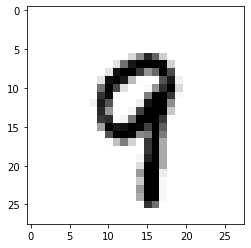

In [91]:
import numpy as np

with np.load("datasets/mnist.npz", allow_pickle=True) as f:
    x_test = (
        f["x_test"] / 255.0
    )  # We must transform the data in the same way as before!

image_index = 1005

display_image(x_test, image_index)

![Output](./img/9.png)

The inference server expects a JSON payload:

In [71]:
import codecs, json

tf_serving_req = {"instances": x_test[image_index : image_index + 1].tolist()}

with open("input.json", "w") as json_file:
    json.dump(tf_serving_req, json_file)

In [72]:
%%sh
set -o errexit
model="mnist"
url="mnist.kubeflow.svc.cluster.local/v1/models/mnist:predict"

curl --fail -L "${url}" -d@input.json -o output.json


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: mnist.kubeflow.svc.cluster.local


CalledProcessError: Command 'b'set -o errexit\nmodel="mnist"\nurl="mnist.kubeflow.svc.cluster.local/v1/models/mnist:predict"\n\ncurl --fail -L "${url}" -d@input.json -o output.json\n'' returned non-zero exit status 6.

The probabilities for each class (0-9) are shown in the `predictions` response.
The model believes the image shows a "9", which indeed it does!

For more details on the URL, please check out this [example](https://github.com/kubeflow/kfserving/tree/master/docs/samples/tensorflow#run-a-prediction).